In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import seaborn as sns



In [4]:
#Cleaning and column assignment from metadata
f = open("census_columns.txt", "r")
content = f.read()
content_list = content.splitlines()

        
for x in range(0, len(content_list)-1):
    if "ignore" in content_list[x]:
        del content_list[x]

        
columns = []
for x in range(0, len(content_list)-1):
    columns.append(content_list[x].split(":")[0])
columns.append('target')
    
df_train =pd.read_csv('census_income_learn.csv')
df_train.columns = columns
    
df_test =pd.read_csv('census_income_test.csv')
df_test.columns = columns


In [5]:
#EDA
df_train.shape
df_test.shape

df_train.info()
df_test.info()

print("")

dup_train = df_train.duplicated()
print("duplicates in training:", dup_train.sum())

dup_test = df_test.duplicated()
print("duplicates in test:", dup_test.sum())

df_train.drop_duplicates(inplace = True)
df_test.drop_duplicates(inplace = True)

print("")
print("class imbalance in train", df_train.groupby('target').size())
print("class imbalance in test", df_test.groupby('target').size())

print(df_train.describe())
print(df_test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199522 entries, 0 to 199521
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199522 non-null  int64  
 1   class of worker                             199522 non-null  object 
 2   detailed industry recode                    199522 non-null  int64  
 3   detailed occupation recode                  199522 non-null  int64  
 4   education                                   199522 non-null  object 
 5   wage per hour                               199522 non-null  int64  
 6   enroll in edu inst last wk                  199522 non-null  object 
 7   marital stat                                199522 non-null  object 
 8   major industry code                         199522 non-null  object 
 9   major occupation code                       199522 non-null  object 
 

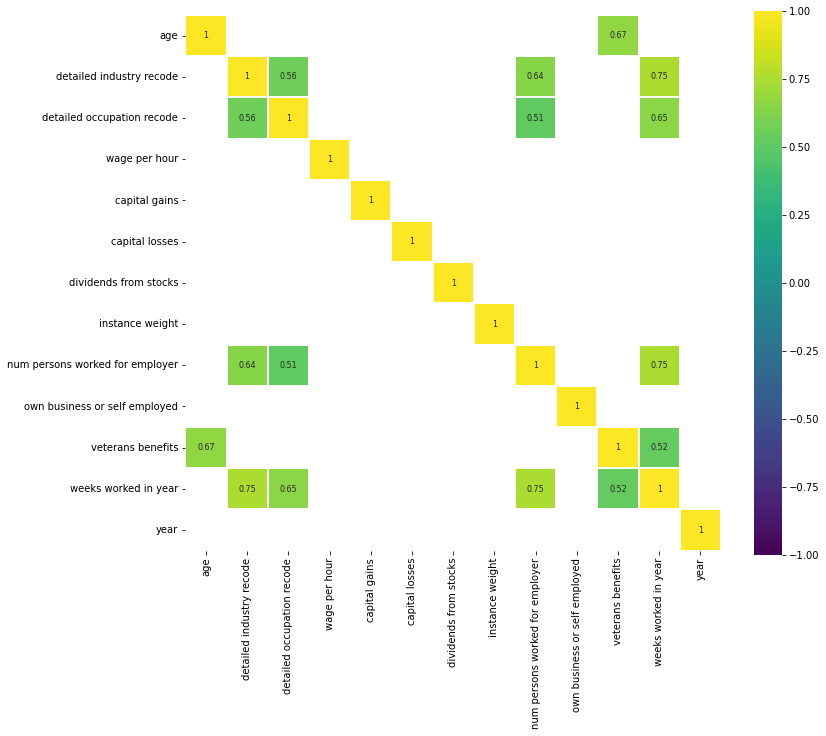

In [6]:
corr = df_test.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)
plt.savefig('heatmap.png', bbox_inches='tight')



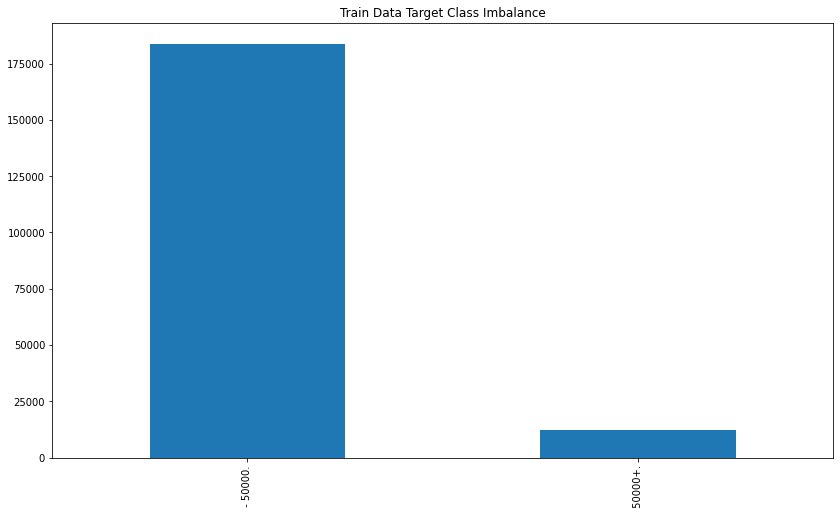

In [7]:
df_train['target'].value_counts().plot(kind='bar',
                                    figsize=(14,8), title = 'Train Data Target Class Imbalance')
plt.savefig('trainBar.png', bbox_inches='tight')



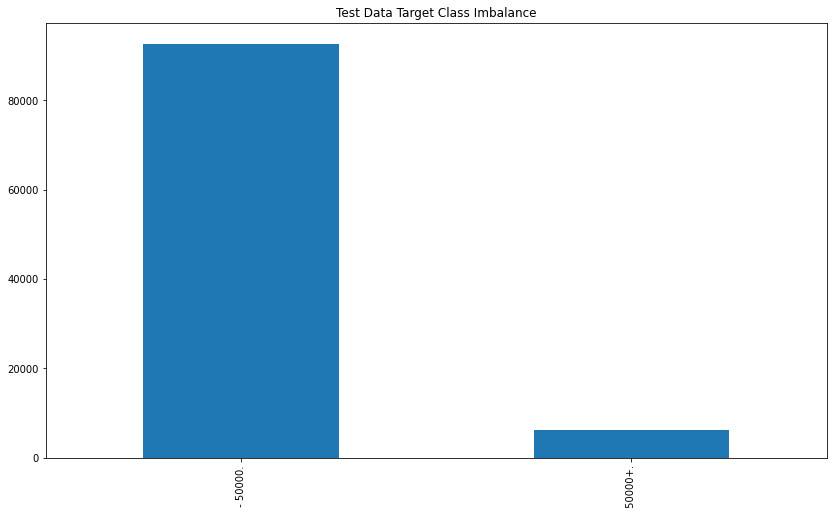

In [8]:
df_test['target'].value_counts().plot(kind='bar',
                                    figsize=(14,8), title = 'Test Data Target Class Imbalance')
plt.savefig('testBar.png', bbox_inches='tight')



In [ ]:
df_minus = df_train[df_train['target']== ' - 50000.']
df_plus = df_train[df_train['target']== ' 50000+.']

print('avg age plus 50', df_plus['age'].mean())
print('avg age minus 50', df_minus['age'].mean())

var = 'race'
plt.hist(df_minus[var], color = 'b', label = 'Less than 50K', alpha = .3, edgecolor = 'black')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('minusracedist.png')
plt.show()

var = 'race'
plt.hist(df_plus[var], color = 'r', label = 'Greater Than 50K', alpha = .6, edgecolor = 'black')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('plusracedist.png')
plt.show()

var = 'capital gains'
plt.hist(df_minus[var], color = 'b', label = 'Less Than 50K', alpha = .3, edgecolor = 'black')
plt.hist(df_plus[var], color = 'r', label = 'Greater Than 50K', alpha = .6, edgecolor = 'black')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('capitalgainsdist.png')
plt.show()
print(sum(df_minus[var])/len(df_minus[var]))
print(sum(df_plus[var]/len(df_plus[var])))

In [6]:
df_train = pd.get_dummies(df_train, drop_first = True)
df_test = pd.get_dummies(df_test, drop_first = True)


df_train, df_test = df_train.align(df_test, join='left', axis=1)

#Split X and Y for train and test data
targetvar = df_train.columns[-1]

y_train = df_train[targetvar]
X_train = df_train.drop(targetvar, axis = 1)

y_test = df_test[targetvar]
X_test = df_test.drop(targetvar, axis = 1)


In [ ]:
df_plus = df_train[df_train[targetvar] == 1]
df_minus = df_train[df_train[targetvar]==0]
plt.hist(df_minus['age'], color = 'b', label = 'Less than 50K', alpha = .3, edgecolor = 'black')
plt.hist(df_plus['age'], color = 'r', label = 'Greater than 50K', alpha = .6, edgecolor = 'black')
plt.title("Age Distribution of Dataset")
plt.legend()
plt.savefig('agedist.png')
plt.show()

In [10]:
#Chi2 feature selection
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dftrainscores = pd.DataFrame(fit.scores_)
dftraincolumns = pd.DataFrame(X_train.columns)

featureScores = pd.concat([dftraincolumns,dftrainscores],axis=1)
featureScores.columns = ['Variable','Score'] 
featuredf = featureScores.nlargest(6,'Score') 

chi2featurecolumns = list(featuredf.Variable)
chi2X_train = X_train[chi2featurecolumns]
chi2X_test = X_test[chi2featurecolumns]

print("Selected Features via chi2")
print(featuredf)

Selected Features via chi2
                    Variable         Score
4              capital gains  5.761476e+08
6      dividends from stocks  1.204783e+08
5             capital losses  8.394208e+06
11      weeks worked in year  3.372162e+05
1   detailed industry recode  1.550299e+05
3              wage per hour  1.501954e+05


In [11]:
print("Chi2 Feature Selected Model Performance")

lr_pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=42)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(random_state=1,
                                                                  max_iter=5000)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lr_gs = GridSearchCV(estimator=lr_pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

lr_gs.fit(chi2X_train, y_train)
cv_score = lr_gs.best_score_
test_score = lr_gs.score(chi2X_test, y_test)
y_pred = lr_gs.predict(chi2X_test)
print(f'Logistic Regression CV score: {cv_score}\nTest accuracy: {test_score}')
print('test F1 Score:', f1_score(y_test, y_pred))
print(lr_gs.best_params_)



print("")
svm_pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', SVC(random_state=1
                                             ,max_iter=5000)]])

param_grid = [{'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
svm_gs = GridSearchCV(estimator=svm_pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

svm_gs.fit(chi2X_train, y_train)
cv_score = svm_gs.best_score_
test_score = svm_gs.score(chi2X_test, y_test)
y_pred = svm_gs.predict(chi2X_test)
print(f'SVM CV score: {cv_score}\nTest accuracy: {test_score}')
print('test F1 Score:', f1_score(y_test, y_pred))
print(svm_gs.best_params_)



print("")
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
neighbors_grid = [3,4,5,6,7, 8, 9, 10, 11]
param_grid_knn = [{ 'kneighborsclassifier__n_neighbors': neighbors_grid }]
knn_gs = GridSearchCV(estimator = pipe_knn,
                       param_grid = param_grid_knn,
                        scoring='accuracy', 
                      refit=True,
                      cv=10,
                      n_jobs=1)
knn_gs.fit(chi2X_train, y_train)
cv_score = knn_gs.best_score_
test_score = knn_gs.score(chi2X_test, y_test)
y_pred = knn_gs.predict(chi2X_test)
print(f'KNN CV score: {cv_score}\nTest accuracy: {test_score}')
print('test F1 Score:', f1_score(y_test, y_pred))
print(knn_gs.best_params_)


Chi2 Feature Selected Model Performance
Logistic Regression CV score: 0.8742677040254875
Test accuracy: 0.875874452167784
test F1 Score: 0.2520835611943564
{'classifier__C': 1000}



/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).

SVM CV score: 0.7316406878124874
Test accuracy: 0.68629829480637
test F1 Score: 0.1874407701132226
{'classifier__C': 0.001}

KNN CV score: 0.9463455222238029
Test accuracy: 0.9466918829264346
test F1 Score: 0.37658190419869897
{'kneighborsclassifier__n_neighbors': 10}


In [7]:
#Random forest to asses feature importance 
feat_labels = df_train.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

######Paired-down features
threshold = .02
sfm = SelectFromModel(forest, threshold=threshold, prefit=True)
X_selected = sfm.transform(X_train)
print("")
feat_list_subset = []
for f in range(X_selected.shape[1]):
    feat_list_subset.append(feat_labels[indices[f]])
df_train2 = df_train[feat_list_subset]
df_test2 = df_test[feat_list_subset]


X = df_train2.iloc[:, :]
X = df_test2.iloc[:, :]

rfX_train = df_train2

rfX_test = df_test2

feature_array = []
for f in range(rfX_train.shape[1]):
    feature_array.append([feat_labels[indices[f]], 
            importances[indices[f]]])
featuredf = pd.DataFrame(feature_array)
featuredf.columns = ['feature', 'importance']

print("Selected Features via Random Forrest")
print(featuredf)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Selected Features via Random Forrest
                                    feature  importance
0           num persons worked for employer    0.081209
1                  detailed industry recode    0.080882
2                           instance weight    0.073022
3                             wage per hour    0.063583
4                            capital losses    0.063438
5                detailed occupation recode    0.040362
6             own business or self employed    0.037954
7                                      year    0.030096
8  member of a labor union_ Not in universe    0.025630
9                     dividends from stocks    0.020626


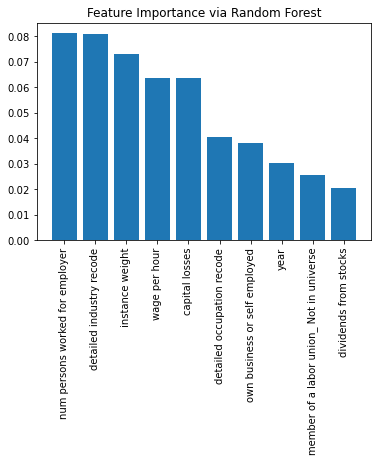

In [10]:
plt.bar(featuredf.feature, 
        featuredf.importance,
        align='center')
plt.xticks(rotation=90)
plt.title('Feature Importance via Random Forest') 
plt.savefig('randomforest.png', bbox_inches = 'tight')
plt.show()

In [15]:
print("Random Forest Feature Selected Model Performance")

lr_pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=42)],
                                ['scaler', MinMaxScaler()],
                                ['classifier', LogisticRegression(random_state=1,
                                                                  max_iter=5000)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)
    
param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lr_gs = GridSearchCV(estimator=lr_pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

lr_gs.fit(rfX_train, y_train)
cv_score = lr_gs.best_score_
test_score = lr_gs.score(rfX_test, y_test)
y_pred = lr_gs.predict(rfX_test)
print(f'Logistic Regression CV score: {cv_score}\nTest accuracy: {test_score}')
print('test F1 Score:', f1_score(y_test, y_pred))
print(lr_gs.best_params_)





print("")
svm_pipeline = imbpipeline(steps = [['smote', SMOTE(random_state=42)],
                                ['scaler', StandardScaler()],
                                ['classifier', SVC(random_state=1
                                             ,max_iter=5000)]])

param_grid = [{'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
svm_gs = GridSearchCV(estimator=svm_pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

svm_gs.fit(rfX_train, y_train)
cv_score = svm_gs.best_score_
test_score = svm_gs.score(rfX_test, y_test)
y_pred = svm_gs.predict(rfX_test)
print(f'SVM CV score: {cv_score}\nTest accuracy: {test_score}')
print('test F1 Score:', f1_score(y_test, y_pred))
print(svm_gs.best_params_)




print("")
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
neighbors_grid = [3,4,5,6,7, 8, 9, 10, 11]
param_grid_knn = [{ 'kneighborsclassifier__n_neighbors': neighbors_grid }]
knn_gs = GridSearchCV(estimator = pipe_knn,
                       param_grid = param_grid_knn,
                        scoring='accuracy', 
                      refit=True,
                      cv=10,
                      n_jobs=1)
knn_gs.fit(rfX_train, y_train)
cv_score = knn_gs.best_score_
test_score = knn_gs.score(rfX_test, y_test)
y_pred = knn_gs.predict(rfX_test)
print(f'KNN CV score: {cv_score}\nTest accuracy: {test_score}')
print('test F1 Score:', f1_score(y_test, y_pred))
print(knn_gs.best_params_)



Random Forest Feature Selected Model Performance
Logistic Regression CV score: 0.8059404602187068
Test accuracy: 0.8082649435558226
test F1 Score: 0.26743641753783737
{'classifier__C': 1000}



/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).

SVM CV score: 0.6227883602877157
Test accuracy: 0.5611912800175249
test F1 Score: 0.10860976625914061
{'classifier__C': 0.1}

KNN CV score: 0.9402424002433112
Test accuracy: 0.9408159550152714
test F1 Score: 0.2388137356919875
{'kneighborsclassifier__n_neighbors': 10}
